In [1]:
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
data_dir = "data"
validation_dir = data_dir + "/Validation"

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1, # horizontal shift
        height_shift_range = 0.1, # vertical shift
        shear_range = 0.1 # shearing range
)

In [5]:
train_generator = datagen.flow_from_directory(
                      directory='data/Train/',
                      target_size=(32, 32), # resize to this size
                      color_mode="rgb", # for coloured images
                      batch_size=256,
                      class_mode='categorical', # classes to predict
                      seed=42 # to make the result reproducible
                  )

Found 35289 images belonging to 43 classes.


In [6]:
datagen = ImageDataGenerator()
validation_generator = datagen.flow_from_directory(
                      directory= validation_dir,
                      target_size=(32, 32), # resize to this size
                      batch_size=256,
                      color_mode="rgb", # for coloured images
                      seed=42 # to make the result reproducible
                  )

Found 3920 images belonging to 43 classes.


In [7]:
test_generator = datagen.flow_from_directory(
                      directory= 'data/Test/',
                      target_size=(32, 32), # resize to this size
                      batch_size=256,
                      color_mode="rgb", # for coloured images
                      shuffle=False,
                      seed=42 # to make the result reproducible
                  )

Found 12630 images belonging to 43 classes.


In [8]:
from tensorflow.keras import Sequential, optimizers, layers
from tensorflow.keras.applications.vgg16 import VGG16

In [9]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

In [10]:
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(43, activation='softmax')
])

In [11]:
#Optimizer
optimizer = optimizers.Adam()

#Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                22059     
Total params: 14,999,403
Trainable params: 14,999,403
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [13]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[es]
)

Epoch 1/50
138/138 [==============================] - 39s 282ms/step - loss: 4.0935 - accuracy: 0.0617 - val_loss: 3.3408 - val_accuracy: 0.0885
Epoch 2/50
138/138 [==============================] - 26s 191ms/step - loss: 3.1113 - accuracy: 0.1248 - val_loss: 2.5684 - val_accuracy: 0.2092
Epoch 3/50
138/138 [==============================] - 26s 188ms/step - loss: 2.3635 - accuracy: 0.2512 - val_loss: 2.0500 - val_accuracy: 0.3199
Epoch 4/50
138/138 [==============================] - 26s 189ms/step - loss: 1.8459 - accuracy: 0.3758 - val_loss: 1.3219 - val_accuracy: 0.5031
Epoch 5/50
138/138 [==============================] - 26s 191ms/step - loss: 1.1844 - accuracy: 0.5722 - val_loss: 0.8066 - val_accuracy: 0.7102
Epoch 6/50
138/138 [==============================] - 27s 198ms/step - loss: 0.7820 - accuracy: 0.7289 - val_loss: 0.5164 - val_accuracy: 0.8245
Epoch 7/50
138/138 [==============================] - 26s 191ms/step - loss: 0.5473 - accuracy: 0.8163 - val_loss: 0.3614 - val_ac

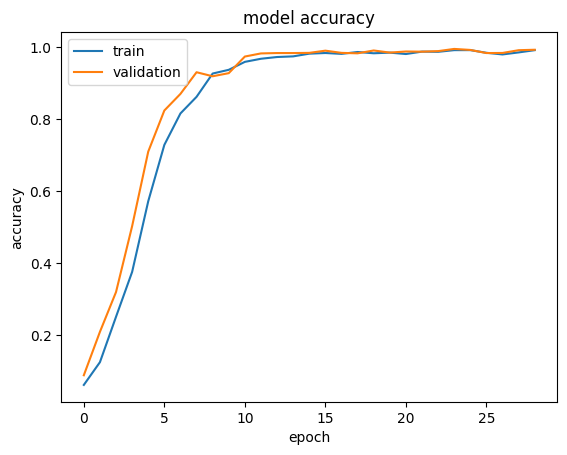

In [14]:
#plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

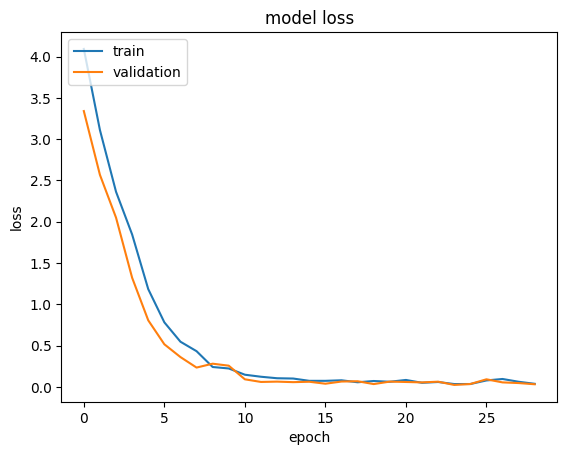

In [15]:
#plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

50/50 [==============================] - 8s 166ms/step - loss: 0.2042 - accuracy: 0.9684


In [17]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.labels, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       0.99      1.00      0.99       720
           2       1.00      0.99      1.00       660
           3       0.98      0.94      0.96       420
           4       1.00      0.98      0.99       690
           5       0.99      0.99      0.99       720
           6       0.96      1.00      0.98       270
           7       0.99      1.00      0.99       210
           8       1.00      0.99      1.00       150
           9       1.00      0.98      0.99       360
          10       1.00      0.77      0.87       390
          11       1.00      1.00      1.00        60
          12       0.99      0.99      0.99       750
          13       0.92      1.00      0.96        90
          14       0.96      0.89      0.92        90
          15       1.00      0.76      0.86       120
          16       0.97      0.97      0.97       150
          17       0.97    

In [18]:
model.save(data_dir+"/model_transfer.h5")